In [1]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor, SimpleRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
#import skimage as ski  
#from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-08-23T13:19:01.999 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


In [3]:
df_input_raw = pd.read_csv('./BVData.csv', comment='#') #, index_col=False, parse_dates=['DATETIME'], comment='#')
df_input_raw = df_input_raw.drop(columns=['Unnamed: 0']).\
    rename(columns={'Unnamed: 1':'timestamp'})

df_input_raw = df_input_raw.iloc[1: , :]
df_input_raw['timestamp'] = pd.to_datetime(df_input_raw['timestamp'])
#df_input_raw['deviceid'] = 'mydevice'

In [4]:
df_input_raw

,timestamp,Unit 2\AMBIENT TEMPERATURE,ID Fan A\ID Fan 1Status (2=ON1=OFF),ID Fan A\IDF A FLUE GAS INLET TEMP,ID Fan A\FLUE GAS FLOW (SIDE A),ID Fan A\IDF A BLADE POSN DEMAND,ID Fan A\ID Fan 1Pressure Rise Actual
1,2016-01-01 06:00:00,44.5185547,2,314.324219,690.773438,66.9082,29.3205566
2,2016-01-01 07:00:00,43.777832,2,305.828125,685.625,69.2568359,31.3203125
3,2016-01-01 08:00:00,44.1640625,2,311.5664,656.6797,67.39258,29.81836
4,2016-01-01 09:00:00,43.550293,2,312.839844,618.210938,64.05176,27.2988281
5,2016-01-01 10:00:00,41.47754,2,310.90625,627.375,63.88379,27.54126
...,...,...,...,...,...,...,...
8730,2016-12-31 02:00:00,39.730957,2,313.789063,726.46875,74.66797,35.30127
8731,2016-12-31 03:00:00,39.4667969,2,312.273438,723.039063,73.5625,34.78955
8732,2016-12-31 04:00:00,39.1098633,2,311.734375,726.6172,73.4834,34.76953
8733,2016-12-31 05:00:00,38.5214844,2,311.667969,727.6875,73.40527,34.7993164


In [5]:
df_input = df_input_raw.set_index(['timestamp'])
for col in df_input.columns.tolist():
    df_input[col] = pd.to_numeric(df_input[col])
features = df_input.columns.tolist()[:-1]
targets = df_input.columns.tolist()[-1:]
predictions = ['Pressure Rise Expected']

In [6]:
targets

['ID Fan A\\ID Fan 1Pressure Rise Actual']

In [7]:
features.remove('ID Fan A\\ID Fan 1Status (2=ON1=OFF)')

In [8]:
features

['Unit 2\\AMBIENT TEMPERATURE',
 'ID Fan A\\IDF A FLUE GAS INLET TEMP',
 'ID Fan A\\FLUE GAS FLOW (SIDE A)',
 'ID Fan A\\IDF A BLADE POSN DEMAND']

In [9]:
df_input[df_input['ID Fan A\\ID Fan 1Status (2=ON1=OFF)'] == 1] = np.nan

2021-08-23T13:19:06.537 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-08-23T13:19:06.539 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [10]:
df_input.interpolate(method='spline', order=3)

,Unit 2\AMBIENT TEMPERATURE,ID Fan A\ID Fan 1Status (2=ON1=OFF),ID Fan A\IDF A FLUE GAS INLET TEMP,ID Fan A\FLUE GAS FLOW (SIDE A),ID Fan A\IDF A BLADE POSN DEMAND,ID Fan A\ID Fan 1Pressure Rise Actual
timestamp,,,,,,
2016-01-01 06:00:00,44.518555,2.0,314.324219,690.773438,66.908200,29.320557
2016-01-01 07:00:00,43.777832,2.0,305.828125,685.625000,69.256836,31.320312
2016-01-01 08:00:00,44.164062,2.0,311.566400,656.679700,67.392580,29.818360
2016-01-01 09:00:00,43.550293,2.0,312.839844,618.210938,64.051760,27.298828
2016-01-01 10:00:00,41.477540,2.0,310.906250,627.375000,63.883790,27.541260
...,...,...,...,...,...,...
2016-12-31 02:00:00,39.730957,2.0,313.789063,726.468750,74.667970,35.301270
2016-12-31 03:00:00,39.466797,2.0,312.273438,723.039063,73.562500,34.789550
2016-12-31 04:00:00,39.109863,2.0,311.734375,726.617200,73.483400,34.769530


In [11]:
# cleaning outliers - metrics below threshold are sensor issues
df_input[df_input[targets[0]] < -10.0] = -10.0
df_input = df_input.fillna(method='bfill')

#df_input[targets[0]][1134] = 34.722168

In [12]:
df_input.reset_index(inplace=True)
df_input['entity'] = 'mydevice'
df_input.set_index(['entity','timestamp'], inplace=True)

In [13]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.INFO)


gbmii = GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=400, learning_rate=0.2, targets=targets,
                     predictions=predictions)
gbmii.correlation_threshold = 0.001
gbmii.experiments_per_execution = 3
gbmii.num_rounds_per_estimator = 3
gbmii.cv = 3

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('Unit 2\AMBIENT TEMPERATURE',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_input = gbmii.execute(df=df_input)

2021-08-23T13:19:11.483 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-08-23T13:19:11.489 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2021-08-23T13:19:11.490 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\\ID Fan 1Pressure Rise Actual.mydevice']
2021-08-23T13:19:11.490 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice has been deleted from filesystem
2021-08-23T13:19:11.491 INFO iotfunctions.base.get_models_for_training predicting target ID Fan A\ID Fan 1Pressure Rise Actual
2021-08-23T13:19:11.491 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice do

In [45]:
len(df_input)

8734

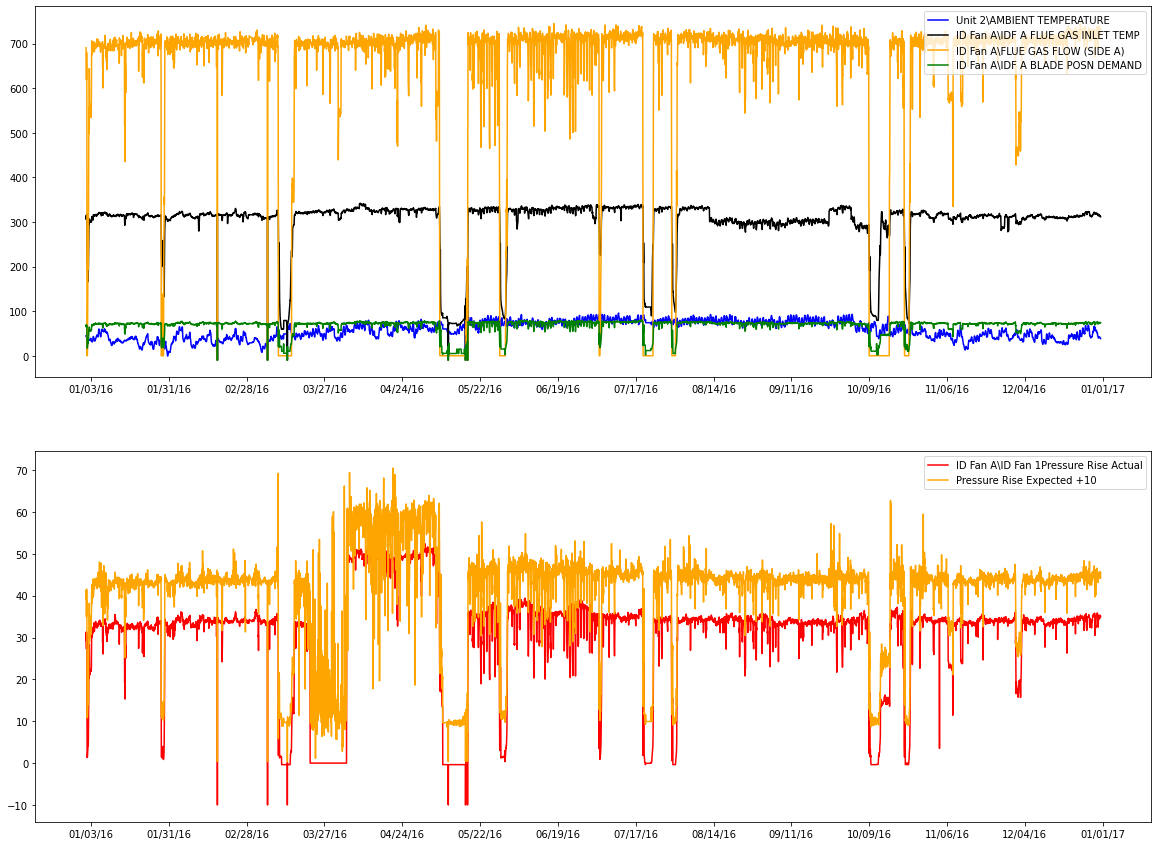

In [14]:
df = df_input.reset_index()
Range = slice(0,10000)
fig, ax = plt.subplots(2,1,figsize=(20,15),squeeze=False)

ax[0,0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=28))
ax[0,0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1,0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=28))
ax[1,0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax[0,0].plot(df[Range]['timestamp'], df[Range][features[0]], color='blue', label=features[0])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[1]], color='black', label=features[1])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[2]], color='orange', label=features[2])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[3]], color='green', label=features[3])
#ax[0,0].plot(df[Range]['timestamp'], df[Range][features[4]]*5, color='magenta', label=features[4] +' *5')
ax[1,0].plot(df[Range]['timestamp'], df[Range][targets[0]], color='red', label=targets[0])
ax[1,0].plot(df[Range]['timestamp'], df[Range][predictions[0]]+10, color='orange', label=predictions[0]+' +10')
ax[0,0].legend()
ax[1,0].legend()



#ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Min'], color='orange', lw=3)
#ax[0].scatter(df[Range]['RCV_TIMESTAMP_UTC'], arr2[Range] + 6.5, color='red', marker='x', lw=5, zorder=10)


In [15]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\\ID Fan 1Pressure Rise Actual.mydevice'
lgbm = gbmii.active_models[modelName][0]
valid_x = gbmii.active_models[modelName][1]
shap_values = shap.TreeExplainer(lgbm.estimator.steps[1][1]).shap_values(valid_x[features])

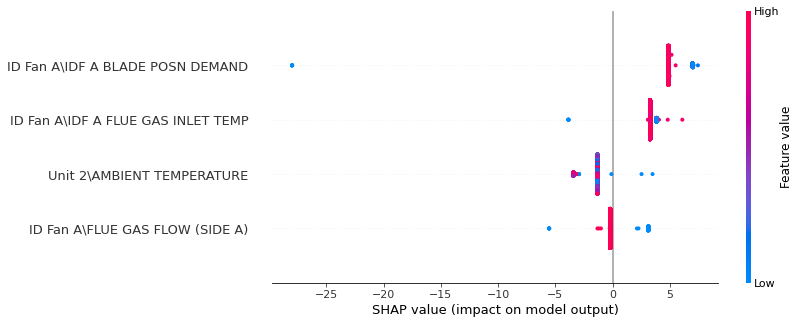

In [16]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))

In [21]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']','').replace('\"', ''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [6]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000


#### Pandas Profiling

Try Pandas Profiling to get an overview about the data, mostly its distributions and correlations
<br>


In [7]:
# profile = ProfileReport(df_input, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile.to_widgets()

In [8]:
df_input2 = df_input.copy()

Indexlist = df_input2.index.to_list()
Indexlist_new = []
for p in Indexlist:
    p_new = ('testentity', p[1])
    Indexlist_new.append(p_new)
df_input2.index = Indexlist_new
df_input = pd.concat([df_input,df_input2])
df_input

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-01 00:02:25.928    3.787826  2.171877  2316.566425   
             2020-01-01 00:07:26.074    3.776503  2.170646  2316.566425   
             2020-01-01 00:12:25.663    3.715573  2.171475  2316.566425   
             2020-01-01 00:17:26.020    3.765538  2.171679  2316.566425   
             2020-01-01 00:22:25.727    3.725934  2.170599  2316.566425   
...                                          ...       ...          ...   
testentity   2020-01-31 11:39:23.476    3.725156  2.171589  2318.802493   
             2020-01-31 11:44:23.497    3.766786  2.170778  2318.802493   
             2020-01-31 11:49:23.443    3.737750  2.171533  2318.802493   
             2020-01-31 11:54:23.499    3.771797  2.172369  2318.802493   
             2020-01-31 11:59:23.501    3.758436  2.171821  2318.802493   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2904         2.2824   
             2020-01-01 00:07:26.074         2.2822         2.2978   
             2020-01-01 00:12:25.663         2.2718         2.2908   
             2020-01-01 00:17:26.020         2.2748         2.2932   
             2020-01-01 00:22:25.727         2.3320         2.2980   
...                                             ...            ...   
testentity   2020-01-31 11:39:23.476         2.2778         2.2798   
             2020-01-31 11:44:23.497         2.2734         2.2704   
             2020-01-31 11:49:23.443         2.2666         2.2714   
             2020-01-31 11:54:23.499         2.2722         2.2738   
             2020-01-31 11:59:23.501         2.2760         2.2716   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2858         2.2956   
             2020-01-01 00:07:26.074         2.2966         2.3504   
             2020-01-01 00:12:25.663         2.2912         2.3044   
             2020-01-01 00:17:26.020         2.2926         2.3146   
             2020-01-01 00:22:25.727         2.2998         2.3212   
...                                             ...            ...   
testentity   2020-01-31 11:39:23.476         2.2676         2.2718   
             2020-01-31 11:44:23.497         2.2694         2.2728   
             2020-01-31 11:49:23.443         2.2712         2.2690   
             2020-01-31 11:54:23.499         2.2694         2.2704   
             2020-01-31 11:59:23.501         2.2678         2.2760   

                                      accel_power_4  
entity       timestamp                               
04714B6046D5 2020-01-01 00:02:25.928         2.3278  
             2020-01-01 00:07:26.074         2.3190  
             2020-01-01 00:12:25.663         2.3232  
             2020-01-01 00:17:26.020         2.3606  
             2020-01-01 00:22:25.727         2.2860  
...                                             ...  
testentity   2020-01-31 11:39:23.476         2.2668  
             2020-01-31 11:44:23.497         2.2670  
             2020-01-31 11:49:23.443         2.2646  
             2020-01-31 11:54:23.499         2.2650  
             2020-01-31 11:59:23.501         2.2744  

[17240 rows x 8 columns]

In [37]:
# df_input[['accel_power_0','accel_anomaly']].head(20)

# removed 'rms'
#features=['accel_speed','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4'] 
features=['accel_power_4']
targets=['rms']
predictions=['rms_pred']

#### Customer suggested a correlation between vibration and acceleration

so let's try to predict (although correlation tests do not really indicate it)

In [38]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.INFO)


gbmii = GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=targets,
                     predictions=predictions)
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_input = gbmii.execute(df=df_input)

2020-06-16T13:25:50.764 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-16T13:25:50.774 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5']
2020-06-16T13:25:51.410 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-16T13:25:51.411 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-06-16T13:25:52.434 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-06-16T13:25:52.436 INFO iotfunctions.base.get_models_for_training load model None
2020-06-16T13:25:52.438 INFO iotfunctions.base.get_models_for_training training required: True  res

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbm',
                 LGBMRegressor(learning_rate=1e-05, max_depth=20,
                               n_estimators=4000, num_leaves=40,
                               verbosity=2))])
2020-06-16T13:29:13.607 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.testentity
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'vib_pred',
       'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'vib_pred',
       'rms_pred'],
      dtype='object')


[[], [], [], [], []]

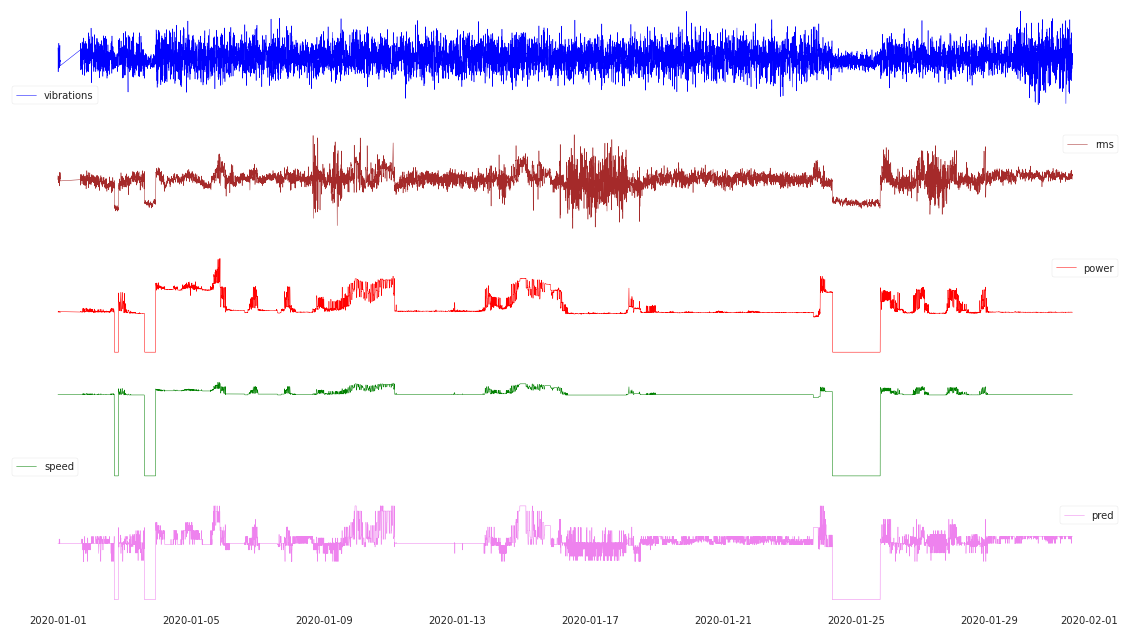

In [39]:
dfg = df_input.loc['04714B6046D5']

fig, ax = plt.subplots(5, 1,figsize=(20,11))

ax[0].plot(dfg.index, dfg['vibrations'], lw=0.5, color='blue', label='vibrations')
ax[1].plot(dfg.index, dfg['rms'], lw=0.5, color='brown', label='rms')
ax[2].plot(dfg.index, dfg['accel_power_0'], lw=0.5, color='red', label='power')
ax[3].plot(dfg.index, dfg['accel_speed'], lw=0.5, color='green', label='speed')
ax[4].plot(dfg.index, dfg['rms_pred'], lw=0.5, color='violet', label='pred')
[ax[i].legend() for i in range(5)]
[ax[i].set_xticks([]) for i in range(4)]
[ax[i].set_yticks([]) for i in range(5)]

In [40]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.rms.04714B6046D5'
lgbm = gbmii.active_models[modelName][0].estimator['gbm']
valid_x = gbmii.active_models[modelName][1]

In [41]:
valid_x

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-04 19:52:33.432    3.802626  2.172146  2459.674775   
             2020-01-18 14:50:11.373    3.740334  2.170717  2314.330357   
             2020-01-24 04:34:32.912    3.758585  2.170179  2408.245212   
             2020-01-11 13:18:08.745    3.724011  2.169324  2325.510697   
             2020-01-26 18:54:46.123    3.765858  2.170675  2329.982833   
...                                          ...       ...          ...   
             2020-01-27 16:19:50.877    3.748594  2.168564  2307.622153   
             2020-01-14 16:48:25.398    3.746864  2.169568  2392.592736   
             2020-01-19 22:20:18.275    3.698115  2.171065  2316.566425   
             2020-01-04 03:57:29.824    3.788656  2.171819  2446.258367   
             2020-01-23 00:00:14.297    3.726920  2.170137  2316.566425   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-04 19:52:33.432         3.8422         3.7914   
             2020-01-18 14:50:11.373         2.2406         2.2454   
             2020-01-24 04:34:32.912         3.4146         3.4270   
             2020-01-11 13:18:08.745         2.3420         2.3364   
             2020-01-26 18:54:46.123         2.3640         2.3840   
...                                             ...            ...   
             2020-01-27 16:19:50.877         2.2468         2.2482   
             2020-01-14 16:48:25.398         2.8016         2.7906   
             2020-01-19 22:20:18.275         2.2390         2.2838   
             2020-01-04 03:57:29.824         3.6274         3.6262   
             2020-01-23 00:00:14.297         2.2484         2.2454   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-04 19:52:33.432         3.7072         3.7686   
             2020-01-18 14:50:11.373         2.2516         2.2536   
             2020-01-24 04:34:32.912         3.4132         3.4262   
             2020-01-11 13:18:08.745         2.3330         2.3330   
             2020-01-26 18:54:46.123         2.3596         2.3908   
...                                             ...            ...   
             2020-01-27 16:19:50.877         2.2440         2.2380   
             2020-01-14 16:48:25.398         2.7562         2.7836   
             2020-01-19 22:20:18.275         2.2930         2.2624   
             2020-01-04 03:57:29.824         3.7418         3.6648   
             2020-01-23 00:00:14.297         2.2510         2.2498   

                                      accel_power_4 vib_pred rms_pred  
entity       timestamp                                                 
04714B6046D5 2020-01-04 19:52:33.432         3.7802  3.75923  2.17048  
             2020-01-18 14:50:11.373         2.2544  3.75942  2.17042  
             2020-01-24 04:34:32.912         3.3920  3.75923   2.1704  
             2020-01-11 13:18:08.745         2.3288  3.75923  2.17043  
             2020-01-26 18:54:46.123         2.3478  3.75923  2.17043  
...                                             ...      ...      ...  
             2020-01-27 16:19:50.877         2.2196  3.75852  2.17041  
             2020-01-14 16:48:25.398         2.7972  3.75923  2.17044  
             2020-01-19 22:20:18.275         2.2454  3.75896  2.17045  
             2020-01-04 03:57:29.824         3.6618  3.75923  2.17048  
             2020-01-23 00:00:14.297         2.2520  3.75929  2.17046  

[6896 rows x 10 columns]

In [42]:

shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x[features])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


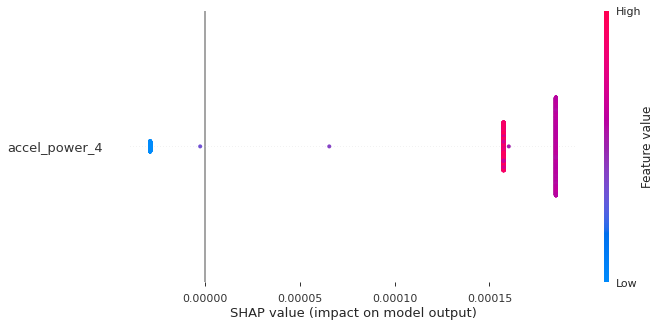

In [43]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))


In [44]:
shap.dependence_plot("accel_speed", shap_values, valid_x[features])

ValueError: Could not find feature named: accel_speed

In [ ]:
#shap.force_plot("accel_power_1", shap_values, valid_x[['accel_power_0','accel_power_1']])
shap.initjs()
test_x = valid_x[features]

test_sample = test_x.iloc[:1000,:]
shap_values_sample = shap.TreeExplainer(lgbm).shap_values(test_sample)
shap.force_plot(shap.TreeExplainer(lgbm).expected_value, shap_values_sample, test_sample,
                link="identity", figsize=(10,4))

In [55]:
print (gbmii._entity_type.db.model_store)

In [12]:
gbmii = GBMRegressor(features=['accel_power_0','accel_power_1'], max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# disallow training and preserve existing models for predict
gbmii.auto_train = False
gbmii.delete_existing_models = False
df_input = gbmii.execute(df=df_input)

2020-03-30T17:38:30.568 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-03-30T17:38:30.569 DEBUG iotfunctions.util.__init__ Starting trace
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMRegressor_20200330153830
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ auto_save None
2020-03-30T17:38:30.571 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-03-30T17:38:30.572 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T17:38:30.573 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-03-30T17:38:30.575 DEBUG mmfunctions.anomaly.execute ['04714B6046D5' 'testentity']
2020-03-30T17:38:30.579 INFO iotfunctions.base.get_models_for_training predic

In [15]:
# Run Monitoring's anomaly detector functions
# EngineLogging.configure_console_logging(logging.DEBUG)

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# allow training and delete existing models
simpleii.auto_train = True
simpleii.delete_existing_models = True
df_input = simpleii.execute(df=df_input)

2020-03-30T19:17:29.485 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:17:29.494 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5']
2020-03-30T19:17:29.981 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:29.984 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:17:30.782 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:30.783 INFO iotfunctions.base.get_models_for_training load model None
2020-03-30T19:17:30.784 INFO iotfunctions.base.get_models_for_training training r

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:34.760 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:34.761 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
2020-03-30T19:17:35.555 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:35.558 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_p

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:42.701 INFO iotfunctions.base.find_best_model Trained model no: 0
2020-03-30T19:17:42.748 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.5410548785172714
2020-03-30T19:17:42.762 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:42.775 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:47.517 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity of size 928905 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:47.518 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity
2020-03-30T19:17:58.372 INFO iotfunctions.dbtables.retrieve_model Mo

In [16]:

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# disallow training and preserve existing models for predict
simpleii.auto_train = False
simpleii.delete_existing_models = False
df_input = simpleii.execute(df=df_input)


2020-03-30T19:21:16.718 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:21:16.722 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:21:17.523 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:21:17.525 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5",
 "target": "rms",
 "features": [
  "accel_power_0",
  "accel_power_1"
 ],
 "estimator_name": "sgd_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": -1.0187012829267998,
 "eval_metric_test": -1.0230987986948104,
 "trained_date": "2020-03-30T17:17:34.254244",
 "expiry_date": null
}
2020-03-30T19:21:17.525 INFO iotfun